<a href="https://colab.research.google.com/github/ramtiin/Attention-Based-LSTM-Network-for-Predicting-Times-Series/blob/master/Traffic_forecasting_using_different_methods.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (7,4.5) # Make the default figures a bit bigger
import numpy as np
import random
import tensorflow as tf
from tensorflow.keras.layers import TimeDistributed,LSTM,ConvLSTM2D,Flatten,Dense,RepeatVector,Conv1D,MaxPooling1D,Bidirectional,Dropout,Reshape,GRU
from tensorflow.keras.models import Sequential
from numpy import linalg as la
from sklearn.preprocessing import StandardScaler
import pandas as pd
from sklearn.metrics import f1_score, precision_score, confusion_matrix, recall_score, accuracy_score
import IPython
import IPython.display

The traffic_prediction.csv file contains the amount of traffic in 6 crossroads.

We load the data into a Pandas dataframe first:

In [2]:
df = pd.read_csv("traffic_dataset.csv", parse_dates=True)
df.columns = ['Cross_1','Cross_2','Cross_3','Cross_4','Cross_5','Cross_6']
df = df.drop_duplicates()

#Data Visualization

Let's see how the data looks like:

,Cross_1,Cross_2,Cross_3,Cross_4,Cross_5,Cross_6
0,105.0,48.0,30,62.0,31,110.0
1,97.0,41.0,32,55.0,42,103.0
2,76.0,47.0,44,58.0,40,100.0
3,98.0,40.0,39,59.0,43,104.0
4,87.0,41.0,47,49.0,35,112.0


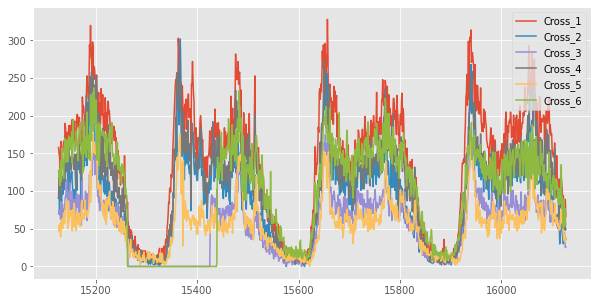

In [8]:
plt.rcParams['figure.figsize']=(10,5)
plt.style.use('ggplot')
df[-1000:].plot()
df.head()

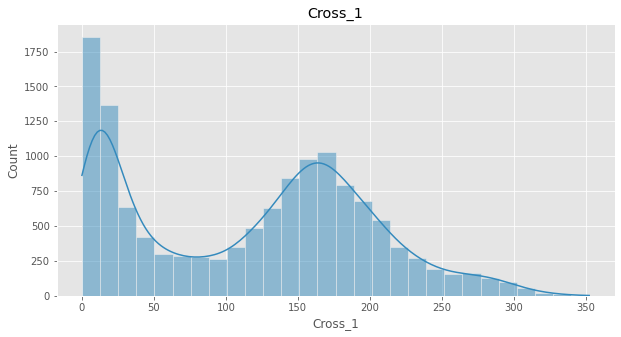

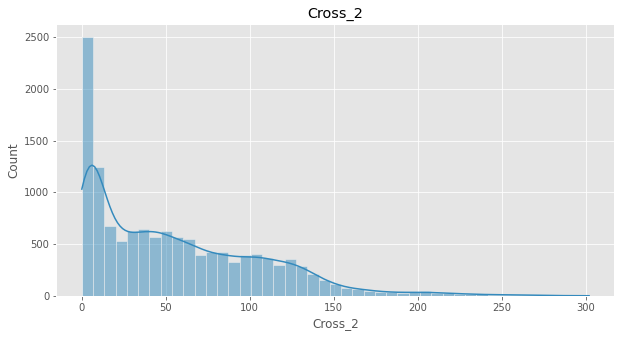

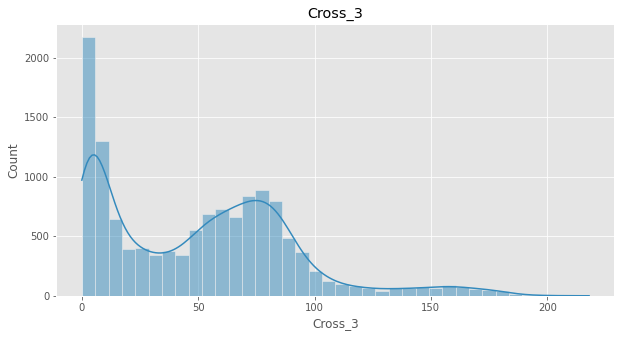

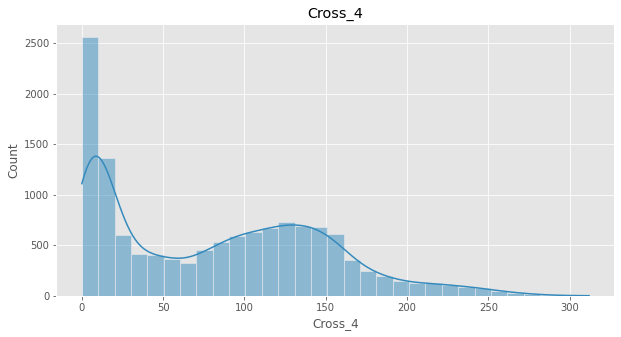

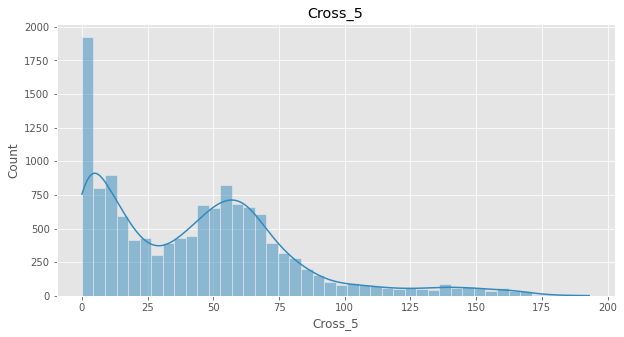

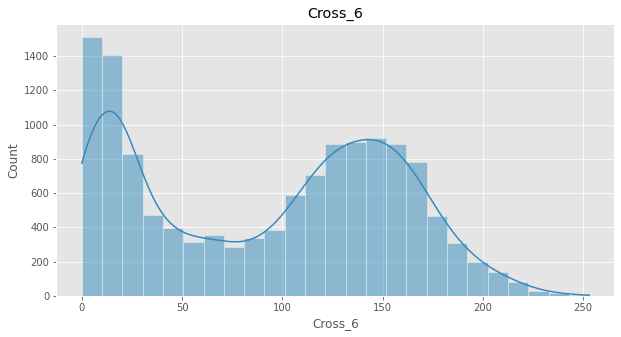

In [9]:
import seaborn as sns
for column in df.columns:
  fig, axes = plt.subplots()
  plt.title(column)
  sns.histplot(df[column], kde = True)

# Check if Time Series Data is Stationary

We interpret this result using the p-value from the ADF test. A p-value below a threshold (such as 5% or 1%) suggests we reject the null hypothesis (stationary), otherwise a p-value above the threshold suggests we fail to reject the null hypothesis (non-stationary).

* p-value > 0.05: Fail to reject the null hypothesis (H0), the data has a unit root and is non-stationary.
* p-value <= 0.05: Reject the null hypothesis (H0), the data does not have a unit root and is stationary.

In [10]:
from pandas import read_csv
from statsmodels.tsa.stattools import adfuller
series = df['Cross_1']
X = series.values
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
	print('\t%s: %.3f' % (key, value))

ADF Statistic: -15.363901
p-value: 0.000000
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567


We can see that our statistic value of -15.363901 is less than the value of -3.431 at 1%. 
This suggests that we can reject the null hypothesis with a significance level of less than 1%.
Rejecting the null hypothesis means that the process has no unit root, and in turn that the time series is stationary or does not have time-dependent structure.

# Splitting the data

We'll use a (70%, 20%, 10%) split for the training, validation, and test sets. Note the data is not being randomly shuffled before splitting. This is for two reasons:



1. It ensures that chopping the data into windows of consecutive samples is still possible.
2. It ensures that the validation/test results are more realistic, being evaluated on the data collected after the model was trained.




In [11]:
column_indices = {name: i for i, name in enumerate(df.columns)}

n = len(df)
train_df = df[0:int(n*0.7)]
val_df = df[int(n*0.7):int(n*0.9)]
test_df = df[int(n*0.9):]

num_features = df.shape[1]

#Normalizing the data

It is important to scale features before training a neural network. Normalization is a common way of doing this scaling: subtract the mean and divide by the standard deviation of each feature.
The mean and standard deviation should only be computed using the training data so that the models have no access to the values in the validation and test sets.

In [12]:
train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

**Distribution of the features:** Some features do have long tails, but there are no obvious errors like the -9999 wind velocity value.

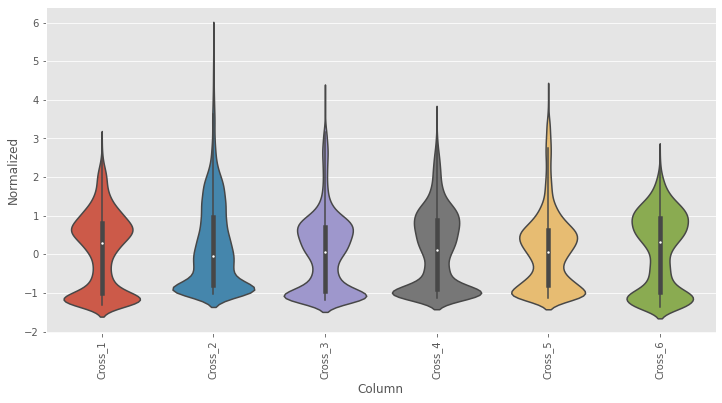

In [13]:
df_std = (df - train_mean) / train_std
df_std = df_std.melt(var_name='Column', value_name='Normalized')
plt.figure(figsize=(12, 6))
ax = sns.violinplot(x='Column', y='Normalized', data=df_std)
_ = ax.set_xticklabels(df.keys(), rotation=90)

# Data windowing

**WindowGenerator class:** The __init__ method includes all the necessary logic for the input and label indices.

It also takes the training, evaluation, and test DataFrames as input. These will be converted to tf.data.Datasets of windows later.

In [14]:
class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
               train_df=train_df, val_df=val_df, test_df=test_df,
               input_columns=None,label_columns=None):
    # Store the raw data.
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    else:
      self.label_columns_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    self.input_columns = input_columns
    if input_columns is not None:
      self.input_columns_indices = {name: i for i, name in
                                    enumerate(input_columns)}
    else:
      self.input_columns_indices = {name: i for i, name in
                           enumerate(train_df.columns)}
                           
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Input column name(s): {self.input_columns_indices}',
        f'Label column name(s): {self.label_columns_indices}'])

**2-Split:** Given a list of consecutive inputs, the split_window method will convert them to a window of inputs and a window of labels.

In [15]:
def split_window(self, features):
  inputs = features[:, self.input_slice, :]
  labels = features[:, self.labels_slice, :]
  if self.label_columns is not None:
    labels = tf.stack(
        [labels[:, :, self.column_indices[name]] for name in self.label_columns],
        axis=-1)
  if self.input_columns is not None:
    inputs = tf.stack(
        [inputs[:, :, self.column_indices[name]] for name in self.input_columns],
        axis=-1)

  # Slicing doesn't preserve static shape information, so set the shapes
  # manually. This way the `tf.data.Datasets` are easier to inspect.
  self.inputs = inputs
  inputs.set_shape([None, self.input_width, None])
  labels.set_shape([None, self.label_width, None])

  return inputs, labels

WindowGenerator.split_window = split_window

**3- Plot:** Here is a plot method that allows a simple visualization of the split window.

In [16]:
def plot(self, model=None, plot_col='Cross_1', max_subplots=3):
  inputs, labels = self.example
  plt.figure(figsize=(15, max_subplots*3))
  plot_col_index = self.column_indices[plot_col]
  max_n = min(max_subplots, len(inputs))
  for n in range(max_n):
    plt.subplot(max_n, 1, n+1)
    plt.ylabel(f'{plot_col} [normed]')
    plt.plot(self.input_indices, inputs[n, :, plot_col_index],
             label='Inputs', marker='.', zorder=-10)

    if self.label_columns:
      label_col_index = self.label_columns_indices.get(plot_col, None)
    else:
      label_col_index = plot_col_index

    if label_col_index is None:
      continue

    plt.scatter(self.label_indices, labels[n, :, label_col_index],
                edgecolors='k', label='Labels', c='#2ca02c', s=64)
    if model is not None:
      predictions = model(inputs)
      plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                  marker='X', edgecolors='k', label='Predictions',
                  c='#ff7f0e', s=64)

    if n == 0:
      plt.legend()

  plt.xlabel('Time [h]')

WindowGenerator.plot = plot

**4- Create tf.data.Datasets:** Finally, this make_dataset method will take a time series DataFrame and convert it to a tf.data.Dataset of (input_window, label_window) pairs using the preprocessing.timeseries_dataset_from_array function:

In [17]:
def make_dataset(self, data):
  data = np.array(data, dtype=np.float32)
  ds = tf.keras.preprocessing.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.total_window_size,
      sequence_stride=1,
      shuffle=True,
      batch_size=32,)

  ds = ds.map(self.split_window)

  return ds

WindowGenerator.make_dataset = make_dataset

The WindowGenerator object holds training, validation, and test data.

Add properties for accessing them as tf.data.Datasets using the make_dataset method you defined earlier. Also, add a standard example batch for easy access and plotting:

In [18]:
@property
def train(self):
  return self.make_dataset(self.train_df)

@property
def val(self):
  return self.make_dataset(self.val_df)

@property
def test(self):
  return self.make_dataset(self.test_df)

@property
def example(self):
  """Get and cache an example batch of `inputs, labels` for plotting."""
  result = getattr(self, '_example', None)
  if result is None:
    # No example batch was found, so get one from the `.train` dataset
    result = next(iter(self.train))
    # And cache it for next time
    self._example = result
  return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example

In [19]:
MAX_EPOCHS = 20

def compile_and_fit(model, window, patience=2):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

  model.compile(loss=tf.losses.MeanSquaredError(),
                optimizer=tf.optimizers.Adam(),
                metrics=[tf.metrics.MeanAbsoluteError()])

  history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks=[early_stopping])
  return history

#Task 1

Predicts a single feature's value—1 time step into the future based only on 1 feature. In this part we'll focus on "Cross_1"

In [ ]:
W1 = WindowGenerator(
    input_width=20,
    label_width=1,
    shift=1,
    input_columns=['Cross_1'],
    label_columns=['Cross_1'])

W1

Total window size: 21
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]
Label indices: [20]
Input column name(s): {'Cross_1': 0}
Label column name(s): {'Cross_1': 0}

Text(0.5, 1.0, 'Given 20 timesteps of inputs, predict 1 timestep into the future.')

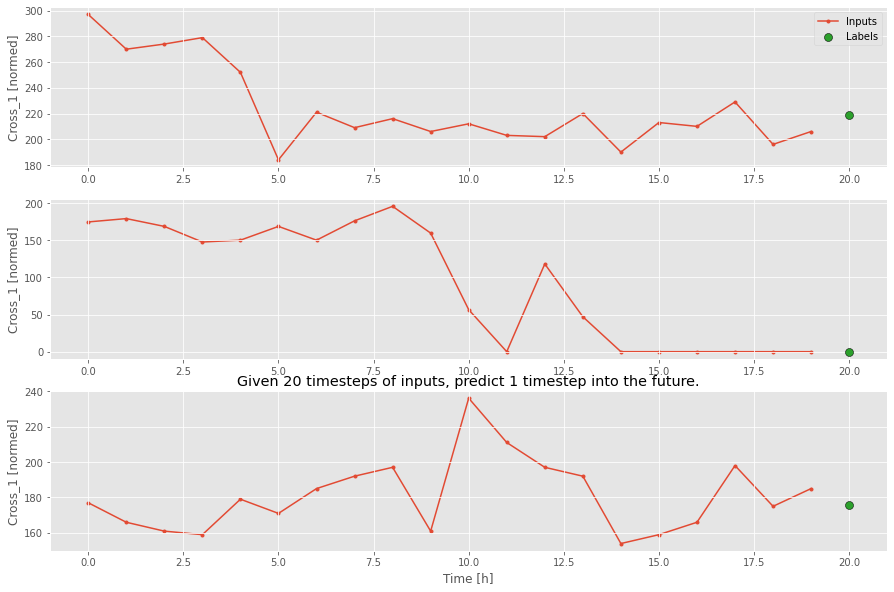

In [ ]:
W1.plot(plot_col='Cross_1')
plt.title("Given 20 timesteps of inputs, predict 1 timestep into the future.")

### Baseline
Before building a trainable model it would be good to have a performance baseline as a point for comparison with the later more complicated models.

So, start with a model that just returns the current value as the prediction, predicting "No change".

In [17]:
class Baseline(tf.keras.Model):
  def __init__(self, label_index=None):
    super().__init__()
    self.label_index = label_index

  def call(self, inputs):
    if self.label_index is None:
      return inputs
    result = inputs[:, :, self.label_index]
    return result[:, :, tf.newaxis]

Instantiate and evaluate this model:

In [ ]:
baseline = Baseline(label_index=column_indices['Cross_1'])

baseline.compile(loss=tf.losses.MeanSquaredError(),
                 metrics=[tf.metrics.MeanAbsoluteError()])

val_performance = {}
performance = {}
val_performance['Baseline'] = baseline.evaluate(W1.val)
performance['Baseline'] = baseline.evaluate(W1.test, verbose=0)

82/82 [==============================] - 1s 6ms/step - loss: 2315.6938 - mean_absolute_error: 32.0235


##Multi-step Dense

In [ ]:
multi_step_dense = Sequential()
multi_step_dense.add(Flatten())
multi_step_dense.add(Dense(64))
multi_step_dense.add(Dense(64))
multi_step_dense.add(Dense(1))
# Add back the time dimension.
# Shape: (outputs) => (1, outputs)
multi_step_dense .add(Reshape([1, -1]))
multi_step_dense .compile(optimizer='adam', loss='mse')

print('Input shape:', W1.example[0].shape)
print('Output shape:', multi_step_dense(W1.example[0]).shape)

Input shape: (32, 20, 1)
Output shape: (32, 1, 1)


In [ ]:
history = compile_and_fit(multi_step_dense, W1)

val_performance['Multi step dense'] = multi_step_dense.evaluate(W1.val)
performance['Multi step dense'] = multi_step_dense.evaluate(W1.test, verbose=0)

Epoch 1/20
289/289 [==============================] - 3s 9ms/step - loss: 1583.7517 - mean_absolute_error: 21.3472 - val_loss: 475.8885 - val_mean_absolute_error: 15.6125
Epoch 2/20
289/289 [==============================] - 2s 8ms/step - loss: 418.4272 - mean_absolute_error: 13.8512 - val_loss: 372.7981 - val_mean_absolute_error: 13.7609
Epoch 3/20
289/289 [==============================] - 2s 7ms/step - loss: 385.2598 - mean_absolute_error: 13.2167 - val_loss: 475.0977 - val_mean_absolute_error: 15.5721
Epoch 4/20
82/82 [==============================] - 1s 5ms/step - loss: 443.9819 - mean_absolute_error: 15.1699


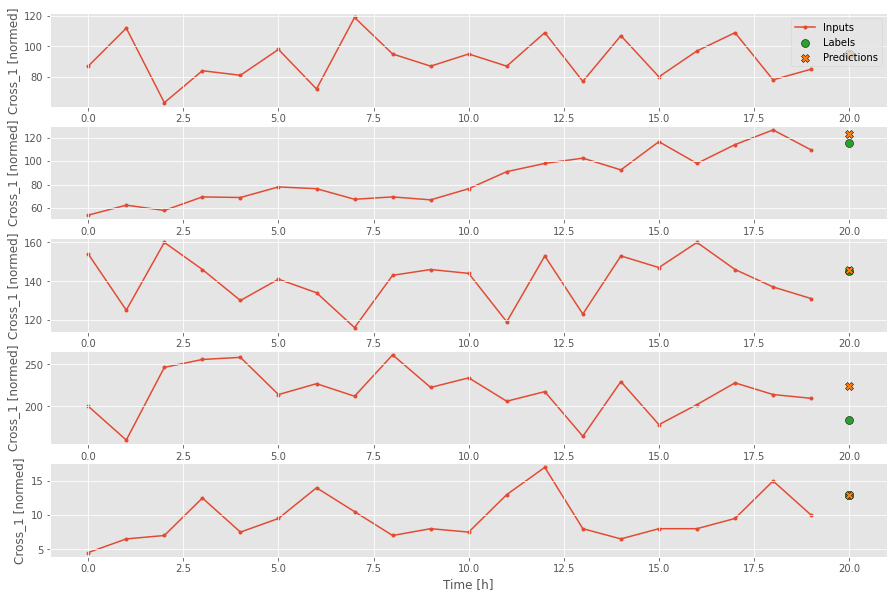

In [ ]:
W1.plot(multi_step_dense,max_subplots=5)

##GRU

In [ ]:
gru_model = Sequential()
gru_model.add(GRU(64,return_sequences = True,input_shape=( W1.example[0].shape[1], W1.example[0].shape[2])))
gru_model.add(GRU(64))
gru_model.add(Dense(1))
# Add back the time dimension.
# Shape: (outputs) => (1, outputs)
gru_model .add(Reshape([1, -1]))
gru_model .compile(optimizer='adam', loss='mse')

print('Input shape:', W1.example[0].shape)
print('Output shape:', gru_model(W1.example[0]).shape)

Input shape: (32, 20, 1)
Output shape: (32, 1, 1)


In [ ]:
history = compile_and_fit(gru_model, W1)

val_performance['GRU model'] = gru_model.evaluate(W1.val)
performance['GRU model'] = gru_model.evaluate(W1.test, verbose=0)

Epoch 1/20
289/289 [==============================] - 9s 18ms/step - loss: 15078.2285 - mean_absolute_error: 93.9517 - val_loss: 16153.1416 - val_mean_absolute_error: 104.0496
Epoch 2/20
289/289 [==============================] - 4s 15ms/step - loss: 12050.9990 - mean_absolute_error: 82.0143 - val_loss: 12900.6318 - val_mean_absolute_error: 91.2026
Epoch 3/20
289/289 [==============================] - 5s 16ms/step - loss: 9605.1533 - mean_absolute_error: 71.6684 - val_loss: 10255.0898 - val_mean_absolute_error: 79.8754
Epoch 4/20
289/289 [==============================] - 5s 16ms/step - loss: 7620.8628 - mean_absolute_error: 62.5068 - val_loss: 8104.5420 - val_mean_absolute_error: 69.4361
Epoch 5/20
289/289 [==============================] - 5s 16ms/step - loss: 6025.3574 - mean_absolute_error: 54.2715 - val_loss: 6383.1646 - val_mean_absolute_error: 60.4181
Epoch 6/20
289/289 [==============================] - 5s 16ms/step - loss: 4754.2686 - mean_absolute_error: 46.9460 - val_loss: 5

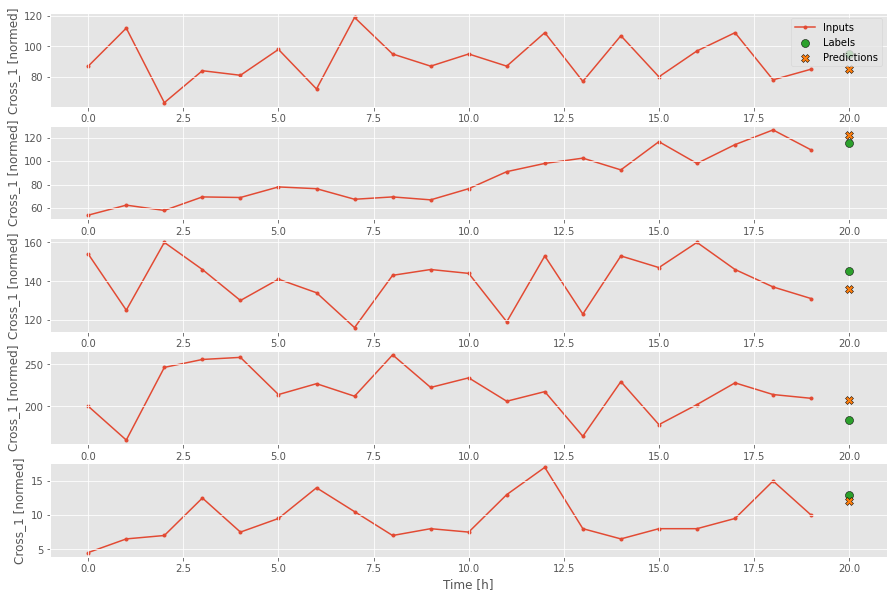

In [ ]:
W1.plot(gru_model,max_subplots=5)

## LSTM

In [ ]:
lstm_model = Sequential()
lstm_model .add(LSTM(64, return_sequences=True,input_shape=( W1.example[0].shape[1], W1.example[0].shape[2])))
lstm_model .add(LSTM(units=64,return_sequences=False))
lstm_model .add(Dense(1,activation='linear'))
# Add back the time dimension.
# Shape: (outputs) => (1, outputs)
lstm_model .add(Reshape([1, -1]))
lstm_model .compile(optimizer='adam', loss='mse')

print('Input shape:', W1.example[0].shape)
print('Output shape:', lstm_model(W1.example[0]).shape)

Input shape: (32, 20, 1)
Output shape: (32, 1, 1)


In [ ]:
history = compile_and_fit(lstm_model, W1)

val_performance['LSTM model'] = lstm_model.evaluate(W1.val)
performance['LSTM model'] = lstm_model.evaluate(W1.test, verbose=0)

Epoch 1/20
289/289 [==============================] - 9s 19ms/step - loss: 15504.7305 - mean_absolute_error: 95.6870 - val_loss: 16309.4932 - val_mean_absolute_error: 104.6215
Epoch 2/20
289/289 [==============================] - 5s 16ms/step - loss: 12133.7031 - mean_absolute_error: 82.3115 - val_loss: 12956.3027 - val_mean_absolute_error: 91.4740
Epoch 3/20
289/289 [==============================] - 5s 16ms/step - loss: 9639.0332 - mean_absolute_error: 71.8632 - val_loss: 10271.7285 - val_mean_absolute_error: 79.8694
Epoch 4/20
289/289 [==============================] - 5s 16ms/step - loss: 7627.0337 - mean_absolute_error: 62.5379 - val_loss: 8098.1436 - val_mean_absolute_error: 69.5137
Epoch 5/20
289/289 [==============================] - 5s 16ms/step - loss: 6025.1895 - mean_absolute_error: 54.2619 - val_loss: 6369.5815 - val_mean_absolute_error: 59.9967
Epoch 6/20
289/289 [==============================] - 5s 16ms/step - loss: 4749.4614 - mean_absolute_error: 46.8956 - val_loss: 5

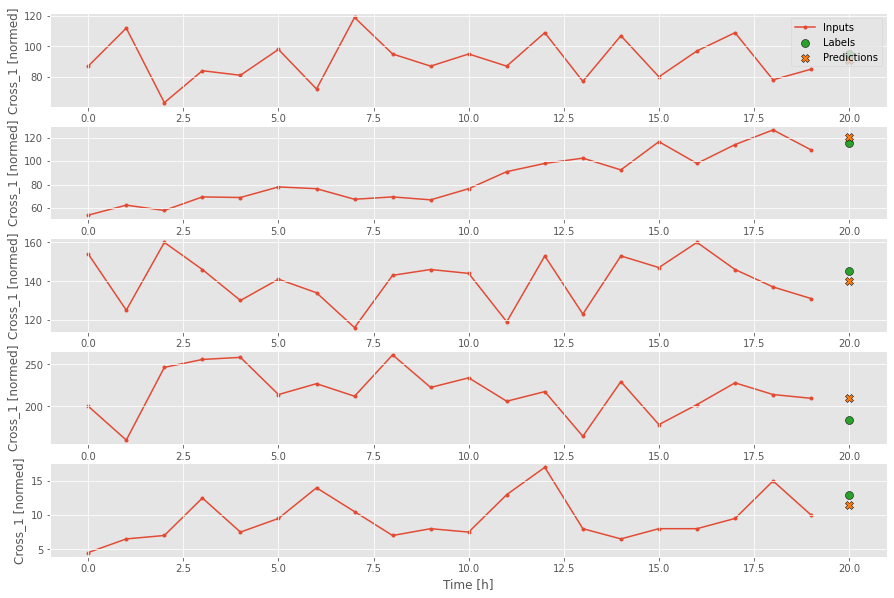

In [ ]:
W1.plot(lstm_model,max_subplots=5)

##Performance

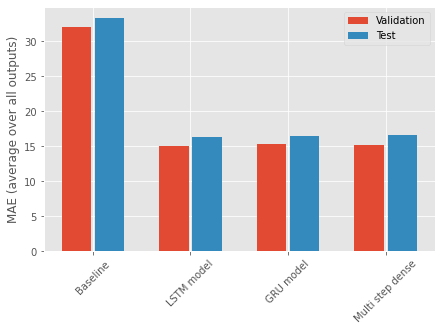

In [ ]:
x = np.arange(len(performance))
width = 0.3

metric_name = 'mean_absolute_error'
metric_index = lstm_model.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in val_performance.values()]
test_mae = [v[metric_index] for v in performance.values()]

plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=performance.keys(),
           rotation=45)
plt.ylabel('MAE (average over all outputs)')
_ = plt.legend()

In [ ]:
for name, value in performance.items():
  print(f'{name:12s}: {value[1]:0.4f}')

Baseline    : 33.2327
LSTM model  : 16.3694
GRU model   : 16.5152
Multi step dense: 16.6168


#Task 2

**Another model that takes 20 past timesteps and predict one step ahead for all feautures. It's called "Multi-output model"**

In [28]:
def multi_plot(self, model=None, plot_col=None, max_subplots=3):
  inputs, labels = self.example

  plt.figure(figsize=(20, max_subplots*8))


  max_n = min(max_subplots, len(inputs))
  for n in range(max_n):
    plt.subplot(max_n, 1, n+1)
    plt.ylabel(f'{plot_col} [normed]')

    p = plt.plot(self.input_indices, inputs[n, :, :],
             label='Inputs', marker='.', zorder=-10)


    if self.label_columns:
        plot_col_index = self.column_indices[plot_col]
        label_col_index = self.label_columns_indices.get(plot_col, None)

    else:
      #plot_col_index = self.column_indices[plot_col]
      label_col_index = self.label_columns_indices

    if label_col_index is None:
      continue

    for i in range (0,len(p)):
      plt.scatter(self.label_indices, labels[n, :, i],
                edgecolors='k',color=p[i].get_color(),label='Labels', s=64)
    if model is not None:
      predictions = model(inputs)
      for i in range (0,len(p)):
          plt.scatter(self.label_indices, predictions[n, :, i],
                  marker='X', edgecolors='k',color=p[i].get_color(), label='Predictions', s=64)

    if n == 0:
      plt.legend(loc='upper left')

  plt.xlabel('Time [h]')

WindowGenerator.multi_plot = multi_plot

In [15]:
W2 = WindowGenerator(
    input_width=20,
    label_width=1,
    shift=1)

W2

Total window size: 21
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]
Label indices: [20]
Input column name(s): {'Cross_1': 0, 'Cross_2': 1, 'Cross_3': 2, 'Cross_4': 3, 'Cross_5': 4, 'Cross_6': 5}
Label column name(s): {'Cross_1': 0, 'Cross_2': 1, 'Cross_3': 2, 'Cross_4': 3, 'Cross_5': 4, 'Cross_6': 5}

##Baseline

The same baseline model (Baseline) can be used here, but this time repeating all features instead of selecting a specific label_index:

In [18]:
baseline = Baseline()
baseline.compile(loss=tf.losses.MeanSquaredError(),
                 metrics=[tf.metrics.MeanAbsoluteError()])


val_performance = {}
performance = {}
val_performance['Baseline'] = baseline.evaluate(W2.val)
performance['Baseline'] = baseline.evaluate(W2.test, verbose=0)

82/82 [==============================] - 1s 3ms/step - loss: 0.4728 - mean_absolute_error: 0.4324


##Multi-step Dense

In [19]:
multi_step_dense = Sequential()
multi_step_dense.add(Flatten())
multi_step_dense.add(Dense(64))
multi_step_dense.add(Dense(64))
multi_step_dense.add(Dense(W2.example[0].shape[2]))
# Add back the time dimension.
# Shape: (outputs) => (1, outputs)
multi_step_dense .add(Reshape([1, -1]))
multi_step_dense .compile(optimizer='adam', loss='mse')

print('Input shape:', W2.example[0].shape)
print('Output shape:', multi_step_dense(W2.example[0]).shape)

Input shape: (32, 20, 6)
Output shape: (32, 1, 6)


In [20]:
history = compile_and_fit(multi_step_dense, W2)

val_performance['Multi step dense'] = multi_step_dense.evaluate(W2.val)
performance['Multi step dense'] = multi_step_dense.evaluate(W2.test, verbose=0)

Epoch 1/20
289/289 [==============================] - 2s 5ms/step - loss: 0.1751 - mean_absolute_error: 0.2722 - val_loss: 0.1015 - val_mean_absolute_error: 0.2296
Epoch 2/20
289/289 [==============================] - 2s 6ms/step - loss: 0.0794 - mean_absolute_error: 0.1955 - val_loss: 0.0821 - val_mean_absolute_error: 0.2052
Epoch 3/20
289/289 [==============================] - 2s 5ms/step - loss: 0.0731 - mean_absolute_error: 0.1876 - val_loss: 0.0799 - val_mean_absolute_error: 0.2034
Epoch 4/20
289/289 [==============================] - 2s 6ms/step - loss: 0.0702 - mean_absolute_error: 0.1837 - val_loss: 0.0818 - val_mean_absolute_error: 0.2052
Epoch 5/20
289/289 [==============================] - 2s 7ms/step - loss: 0.0684 - mean_absolute_error: 0.1804 - val_loss: 0.0782 - val_mean_absolute_error: 0.1993
Epoch 6/20
289/289 [==============================] - 2s 5ms/step - loss: 0.0678 - mean_absolute_error: 0.1794 - val_loss: 0.0772 - val_mean_absolute_error: 0.1987
Epoch 7/20
289/2

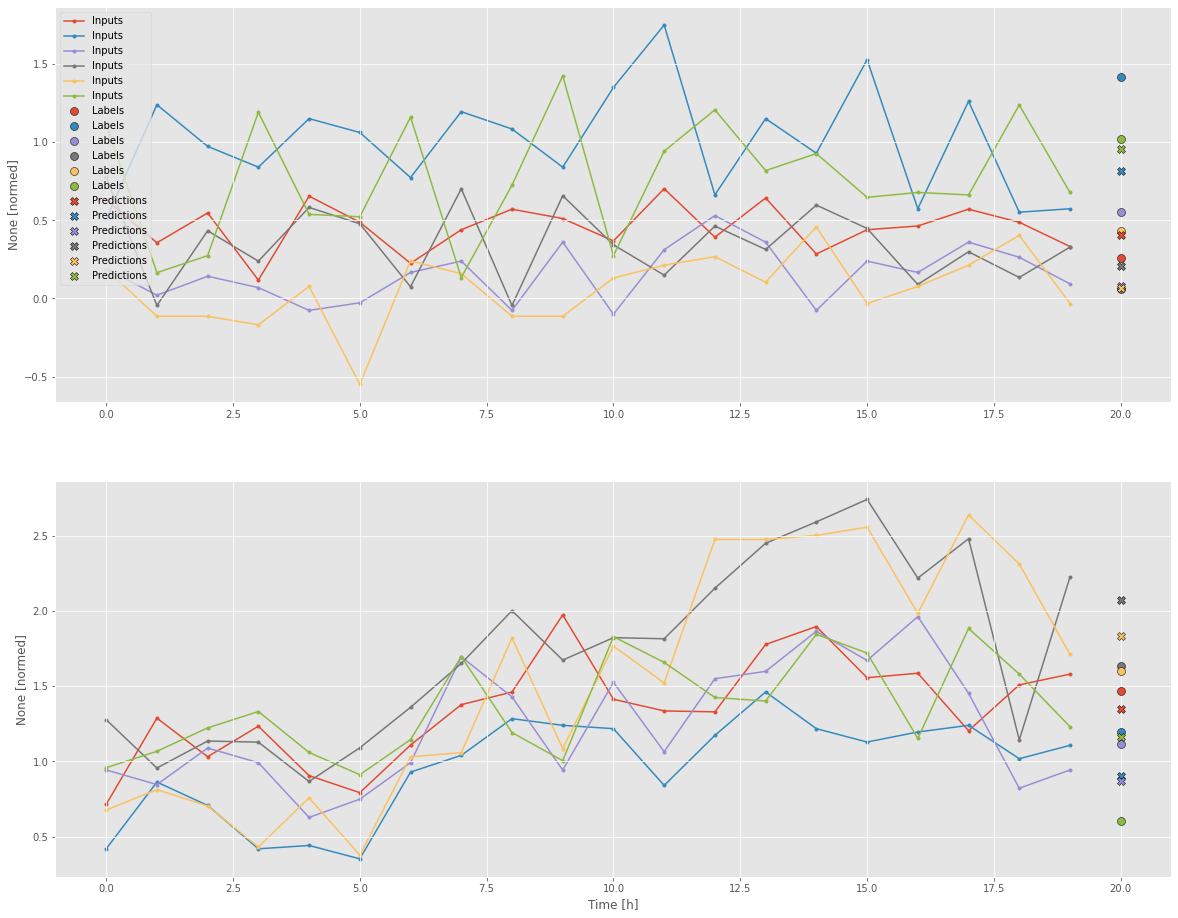

In [59]:
W2.multi_plot(multi_step_dense,max_subplots=2)

##GRU

In [61]:
gru_model = Sequential()
gru_model.add(GRU(64,return_sequences = True,input_shape=( W2.example[0].shape[1], W2.example[0].shape[2])))
gru_model.add(GRU(64))
gru_model.add(Dense(W2.example[0].shape[2]))
# Add back the time dimension.
# Shape: (outputs) => (1, outputs)
gru_model .add(Reshape([1, -1]))
gru_model .compile(optimizer='adam', loss='mse')

print('Input shape:', W2.example[0].shape)
print('Output shape:', gru_model(W2.example[0]).shape)

Input shape: (32, 20, 6)
Output shape: (32, 1, 6)


In [62]:
history = compile_and_fit(gru_model, W2)

val_performance['GRU model'] = gru_model.evaluate(W2.val)
performance['GRU model'] = gru_model.evaluate(W2.test, verbose=0)

Epoch 1/20
289/289 [==============================] - 12s 31ms/step - loss: 0.1008 - mean_absolute_error: 0.2059 - val_loss: 0.0801 - val_mean_absolute_error: 0.1992
Epoch 2/20
289/289 [==============================] - 8s 28ms/step - loss: 0.0635 - mean_absolute_error: 0.1697 - val_loss: 0.0772 - val_mean_absolute_error: 0.1973
Epoch 3/20
289/289 [==============================] - 8s 28ms/step - loss: 0.0606 - mean_absolute_error: 0.1659 - val_loss: 0.0752 - val_mean_absolute_error: 0.1940
Epoch 4/20
289/289 [==============================] - 8s 27ms/step - loss: 0.0593 - mean_absolute_error: 0.1642 - val_loss: 0.0749 - val_mean_absolute_error: 0.1949
Epoch 5/20
289/289 [==============================] - 8s 28ms/step - loss: 0.0589 - mean_absolute_error: 0.1643 - val_loss: 0.0729 - val_mean_absolute_error: 0.1910
Epoch 6/20
289/289 [==============================] - 8s 29ms/step - loss: 0.0580 - mean_absolute_error: 0.1635 - val_loss: 0.0768 - val_mean_absolute_error: 0.1982
Epoch 7/2

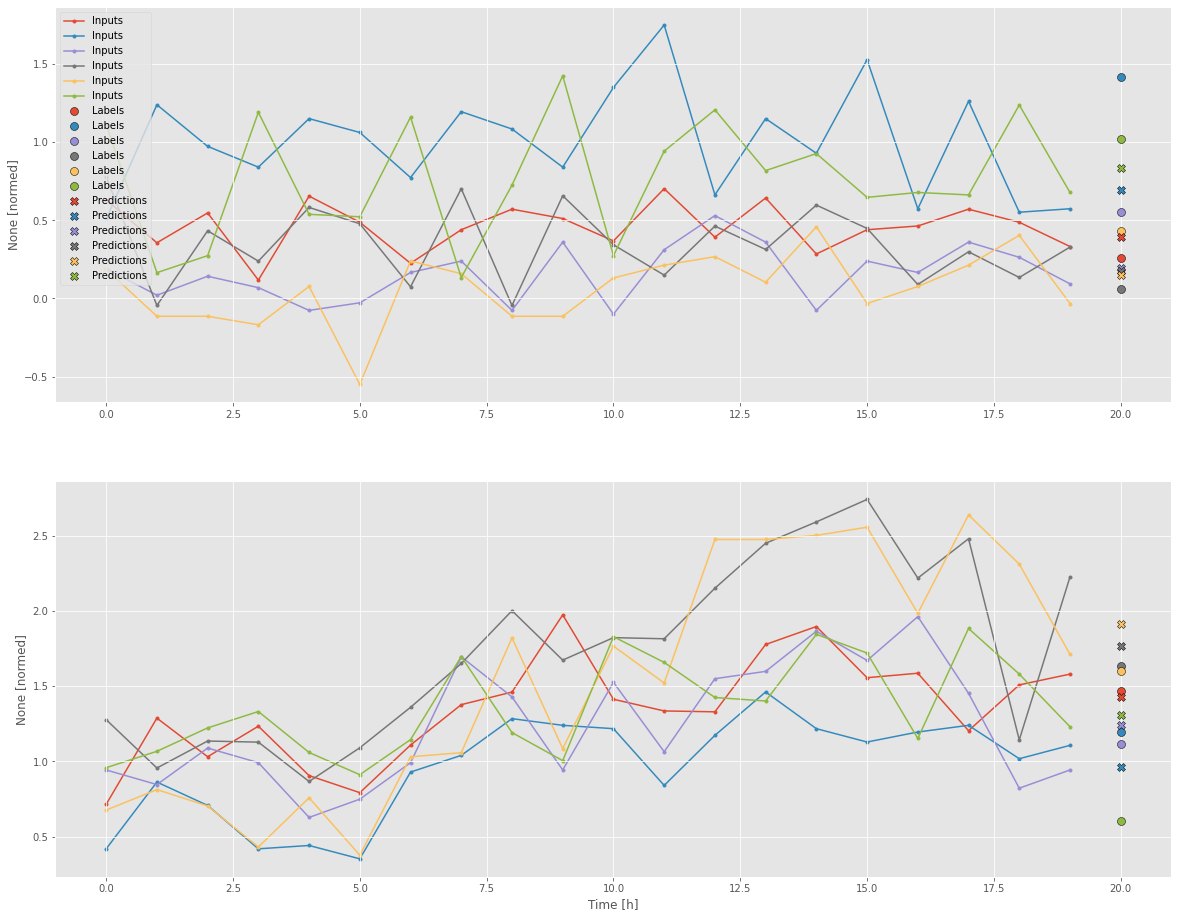

In [63]:
W2.multi_plot(gru_model,max_subplots=2)

##LSTM

In [66]:
lstm_model = Sequential()
lstm_model .add(LSTM(64, return_sequences=True,input_shape=( W2.example[0].shape[1], W2.example[0].shape[2])))
lstm_model .add(LSTM(units=64,return_sequences=False))
lstm_model .add(Dense(W2.example[0].shape[2],activation='linear'))
# Add back the time dimension.
# Shape: (outputs) => (1, outputs)
lstm_model .add(Reshape([1, -1]))
lstm_model .compile(optimizer='adam', loss='mse')

print('Input shape:', W2.example[0].shape)
print('Output shape:', lstm_model(W2.example[0]).shape)

Input shape: (32, 20, 6)
Output shape: (32, 1, 6)


In [68]:
history = compile_and_fit(lstm_model, W2)

val_performance['LSTM model'] = lstm_model.evaluate(W2.val)
performance['LSTM model'] = lstm_model.evaluate(W2.test, verbose=0)

Epoch 1/20
289/289 [==============================] - 12s 31ms/step - loss: 0.1331 - mean_absolute_error: 0.2365 - val_loss: 0.0923 - val_mean_absolute_error: 0.2086
Epoch 2/20
289/289 [==============================] - 8s 29ms/step - loss: 0.0719 - mean_absolute_error: 0.1794 - val_loss: 0.0830 - val_mean_absolute_error: 0.1994
Epoch 3/20
289/289 [==============================] - 8s 29ms/step - loss: 0.0647 - mean_absolute_error: 0.1700 - val_loss: 0.0785 - val_mean_absolute_error: 0.1959
Epoch 4/20
289/289 [==============================] - 8s 29ms/step - loss: 0.0616 - mean_absolute_error: 0.1666 - val_loss: 0.0788 - val_mean_absolute_error: 0.1956
Epoch 5/20
82/82 [==============================] - 1s 9ms/step - loss: 0.0798 - mean_absolute_error: 0.1969


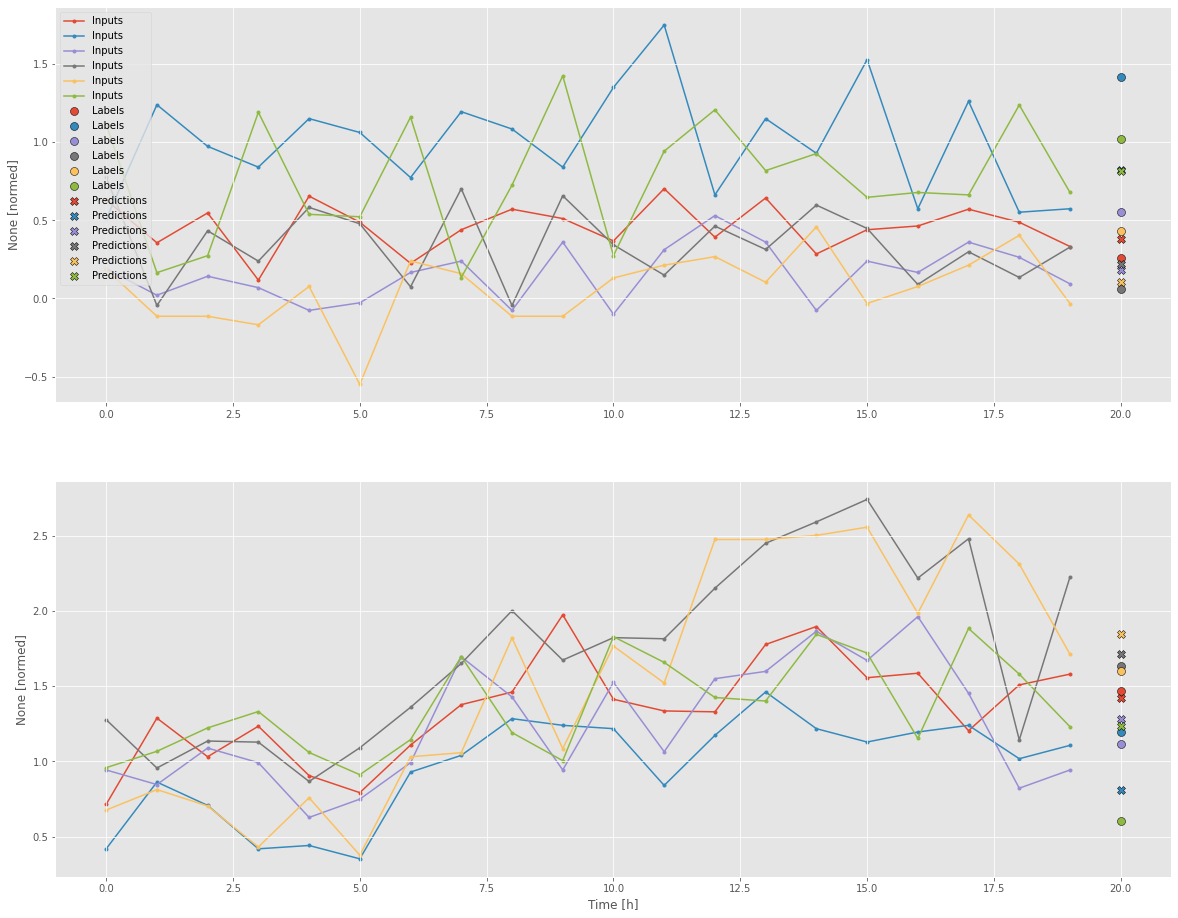

In [69]:
W2.multi_plot(lstm_model,max_subplots=2)

##Performance

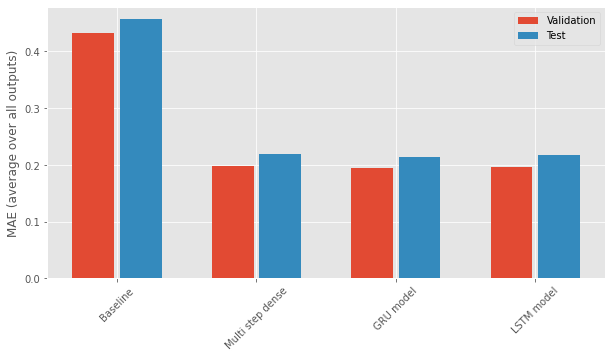

In [70]:
x = np.arange(len(performance))
width = 0.3

metric_name = 'mean_absolute_error'
metric_index = lstm_model.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in val_performance.values()]
test_mae = [v[metric_index] for v in performance.values()]

plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=performance.keys(),
           rotation=45)
plt.ylabel('MAE (average over all outputs)')
_ = plt.legend()

In [71]:
for name, value in performance.items():
  print(f'{name:12s}: {value[1]:0.4f}')

Baseline    : 0.4564
Multi step dense: 0.2197
GRU model   : 0.2136
LSTM model  : 0.2179


#Task 3

**Get the 20 past timesteps of Cross_1 and predict the next 3 timesteps.**

Text(0.5, 1.0, 'Given 20 timesteps of inputs, predict 3 timesteps into the future.')

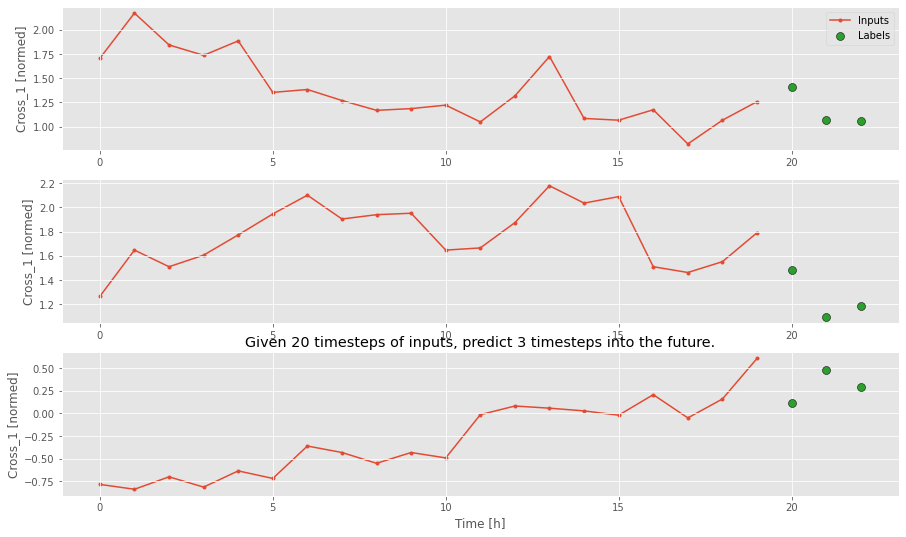

In [42]:
W3 = WindowGenerator(input_width=20,
                               label_width=3,
                               shift=3,
                               input_columns=['Cross_1'],
                               label_columns=['Cross_1'])

W3.plot(plot_col='Cross_1')
plt.title("Given 20 timesteps of inputs, predict 3 timesteps into the future.")

##Baselines

A simple baseline for this task is to repeat the last input time step for the required number of output time steps:

82/82 [==============================] - 0s 3ms/step - loss: 0.0765 - mean_absolute_error: 0.1942


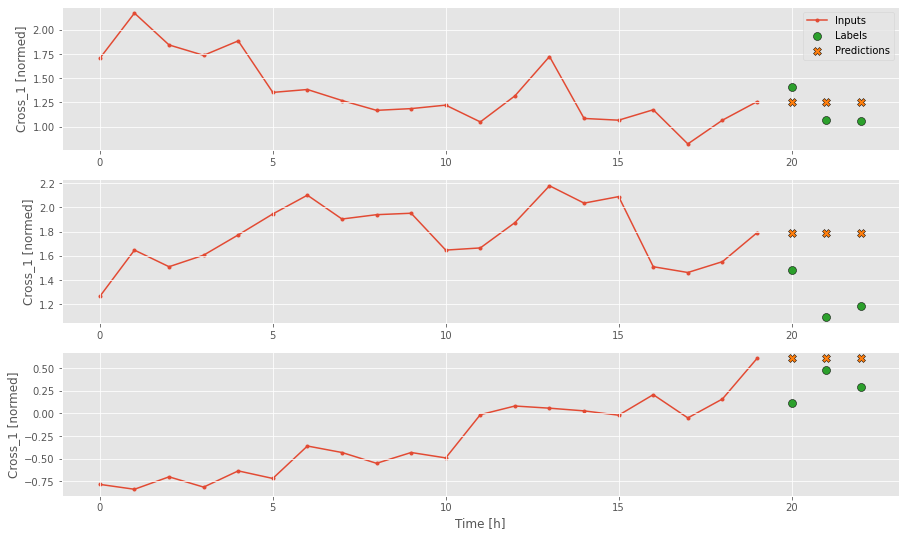

In [43]:
OUT_STEPS = 3
num_features = 1
class MultiStepLastBaseline(tf.keras.Model):
  def call(self, inputs):
    return tf.tile(inputs[:, -1:, :], [1, OUT_STEPS, 1])

last_baseline = MultiStepLastBaseline()
last_baseline.compile(loss=tf.losses.MeanSquaredError(),
                      metrics=[tf.metrics.MeanAbsoluteError()])

multi_val_performance = {}
multi_performance = {}

multi_val_performance['Last'] = last_baseline.evaluate(W3.val)
multi_performance['Last'] = last_baseline.evaluate(W3.test, verbose=0)
W3.plot(last_baseline)

##Multi-step Dense

In [44]:
multi_dense = Sequential()
multi_dense.add(Flatten())
multi_dense.add(Dense(64))
multi_dense.add(Dense(64))
multi_dense.add(Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()))
# Shape => [batch, out_steps*features]
multi_dense .add(Reshape([OUT_STEPS, num_features]))
multi_dense .compile(optimizer='adam', loss='mse')

print('Input shape:', W3.example[0].shape)
print('Output shape:', multi_dense(W3.example[0]).shape)

Input shape: (32, 20, 1)
Output shape: (32, 3, 1)


Epoch 1/20
289/289 [==============================] - 2s 6ms/step - loss: 0.1107 - mean_absolute_error: 0.2187 - val_loss: 0.0690 - val_mean_absolute_error: 0.1815
Epoch 2/20
289/289 [==============================] - 2s 6ms/step - loss: 0.0686 - mean_absolute_error: 0.1753 - val_loss: 0.0679 - val_mean_absolute_error: 0.1811
Epoch 3/20
289/289 [==============================] - 2s 6ms/step - loss: 0.0689 - mean_absolute_error: 0.1762 - val_loss: 0.0681 - val_mean_absolute_error: 0.1817
Epoch 4/20
82/82 [==============================] - 0s 3ms/step - loss: 0.0848 - mean_absolute_error: 0.2213


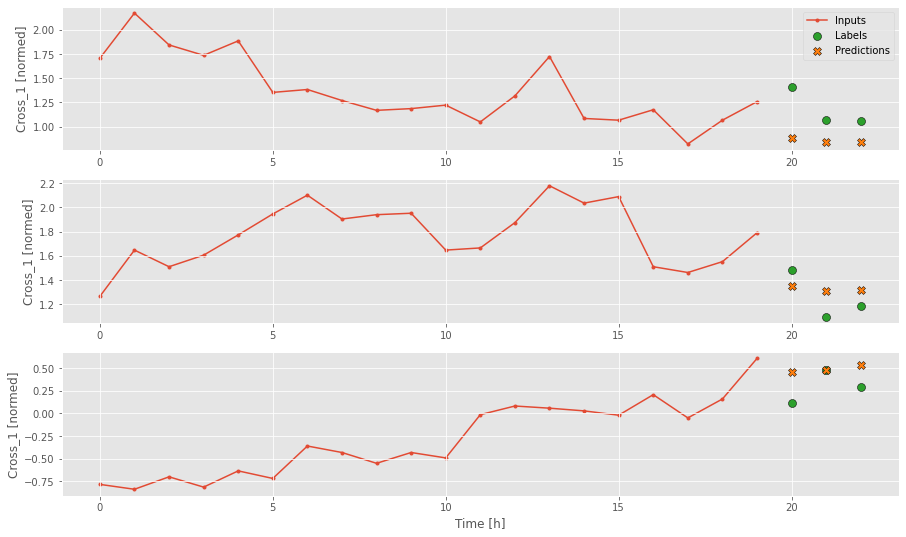

In [45]:
history = compile_and_fit(multi_dense, W3)

multi_val_performance['Dense'] = multi_dense.evaluate(W3.val)
multi_performance['Dense'] = multi_dense.evaluate(W3.test, verbose=0)
W3.plot(multi_dense)

##GRU


In [46]:
gru_model = Sequential()
gru_model.add(GRU(64,return_sequences = True,input_shape=( W3.example[0].shape[1], W3.example[0].shape[2])))
gru_model.add(GRU(64))
gru_model.add(Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()))
gru_model .add(Reshape([OUT_STEPS, num_features]))
gru_model .compile(optimizer='adam', loss='mse')

print('Input shape:', W3.example[0].shape)
print('Output shape:', gru_model(W3.example[0]).shape)

Input shape: (32, 20, 1)
Output shape: (32, 3, 1)


In [47]:
history = compile_and_fit(gru_model, W3)

multi_val_performance['GRU model'] = gru_model.evaluate(W3.val)
multi_performance['GRU model'] = gru_model.evaluate(W3.test, verbose=0)

Epoch 1/20
289/289 [==============================] - 9s 14ms/step - loss: 0.1334 - mean_absolute_error: 0.2320 - val_loss: 0.0667 - val_mean_absolute_error: 0.1774
Epoch 2/20
289/289 [==============================] - 3s 10ms/step - loss: 0.0631 - mean_absolute_error: 0.1645 - val_loss: 0.0610 - val_mean_absolute_error: 0.1698
Epoch 3/20
289/289 [==============================] - 3s 9ms/step - loss: 0.0596 - mean_absolute_error: 0.1609 - val_loss: 0.0620 - val_mean_absolute_error: 0.1771
Epoch 4/20
289/289 [==============================] - 3s 10ms/step - loss: 0.0583 - mean_absolute_error: 0.1593 - val_loss: 0.0586 - val_mean_absolute_error: 0.1703
Epoch 5/20
289/289 [==============================] - 3s 10ms/step - loss: 0.0579 - mean_absolute_error: 0.1584 - val_loss: 0.0589 - val_mean_absolute_error: 0.1725
Epoch 6/20
82/82 [==============================] - 0s 5ms/step - loss: 0.0597 - mean_absolute_error: 0.1733


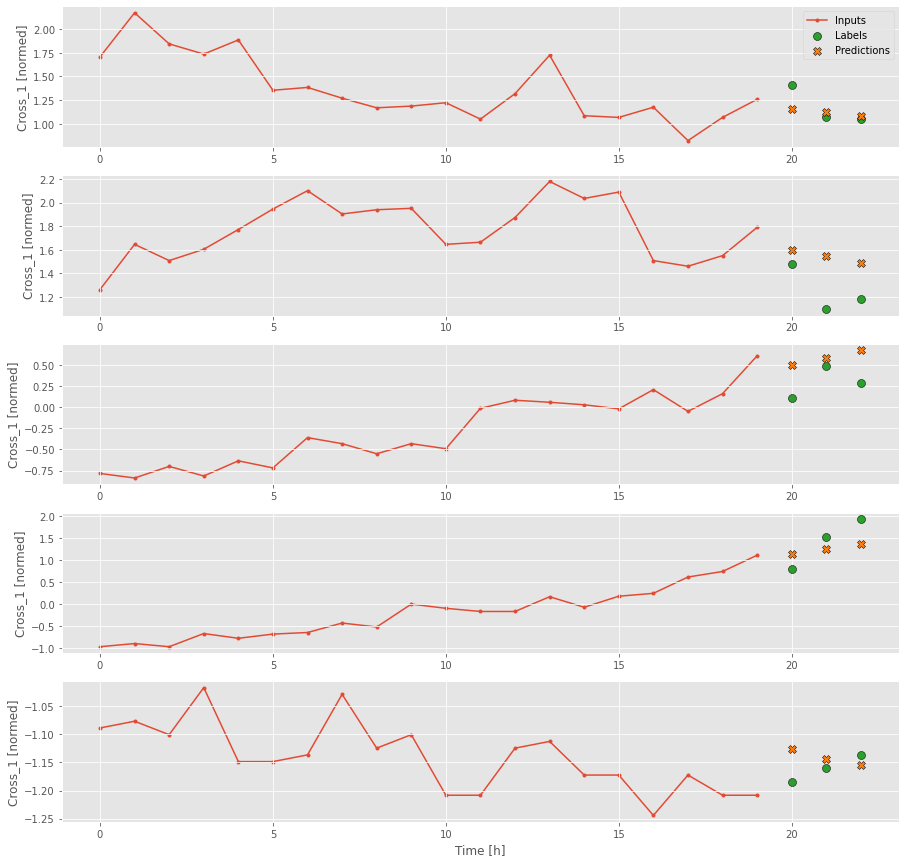

In [48]:
W3.plot(gru_model,max_subplots=5)

##LSTM

In [49]:
multi_lstm_model = Sequential()
multi_lstm_model .add(LSTM(64, return_sequences=True,input_shape=( W3.example[0].shape[1], W3.example[0].shape[2])))
multi_lstm_model .add(LSTM(units=64,return_sequences=False))
multi_lstm_model .add(Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()))
    # Shape => [batch, out_steps, features].
multi_lstm_model .add(Reshape([OUT_STEPS, num_features]))
multi_lstm_model .compile(optimizer='adam', loss='mse')

print('Input shape:', W3.example[0].shape)
print('Output shape:', multi_lstm_model(W3.example[0]).shape)

Input shape: (32, 20, 1)
Output shape: (32, 3, 1)


Epoch 1/20
289/289 [==============================] - 9s 16ms/step - loss: 0.1565 - mean_absolute_error: 0.2508 - val_loss: 0.0754 - val_mean_absolute_error: 0.1914
Epoch 2/20
289/289 [==============================] - 3s 11ms/step - loss: 0.0648 - mean_absolute_error: 0.1656 - val_loss: 0.0638 - val_mean_absolute_error: 0.1803
Epoch 3/20
289/289 [==============================] - 3s 11ms/step - loss: 0.0604 - mean_absolute_error: 0.1594 - val_loss: 0.0667 - val_mean_absolute_error: 0.1908
Epoch 4/20
82/82 [==============================] - 0s 5ms/step - loss: 0.0678 - mean_absolute_error: 0.1883


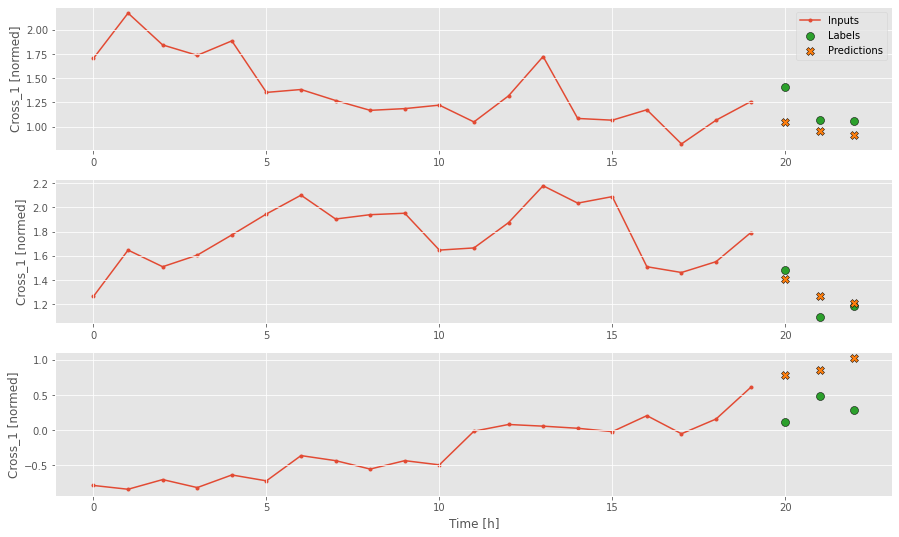

In [50]:
history = compile_and_fit(multi_lstm_model, W3)

multi_val_performance['LSTM'] = multi_lstm_model.evaluate(W3.val)
multi_performance['LSTM'] = multi_lstm_model.evaluate(W3.test, verbose=0)
W3.plot(multi_lstm_model)

##Performance

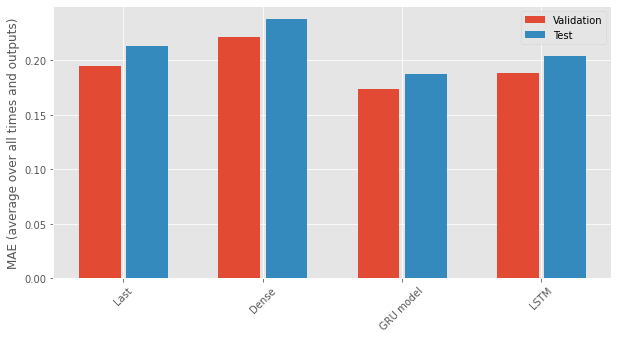

In [51]:
x = np.arange(len(multi_performance))
width = 0.3

metric_name = 'mean_absolute_error'
metric_index = multi_lstm_model.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in multi_val_performance.values()]
test_mae = [v[metric_index] for v in multi_performance.values()]

plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=multi_performance.keys(),
           rotation=45)
plt.ylabel(f'MAE (average over all times and outputs)')
_ = plt.legend()

In [52]:
for name, value in multi_performance.items():
  print(f'{name:8s}: {value[1]:0.4f}')

Last    : 0.2133
Dense   : 0.2376
GRU model: 0.1875
LSTM    : 0.2043


#Task 4

**Get the 20 past timesteps and predict 3 steps ahead for all feautures.**

In [22]:
W4 = WindowGenerator(input_width=20,
                               label_width=3,
                               shift=3)
W4

Total window size: 23
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]
Label indices: [20 21 22]
Input column name(s): {'Cross_1': 0, 'Cross_2': 1, 'Cross_3': 2, 'Cross_4': 3, 'Cross_5': 4, 'Cross_6': 5}
Label column name(s): {'Cross_1': 0, 'Cross_2': 1, 'Cross_3': 2, 'Cross_4': 3, 'Cross_5': 4, 'Cross_6': 5}

##Baselines

82/82 [==============================] - 1s 4ms/step - loss: 0.1201 - mean_absolute_error: 0.2393


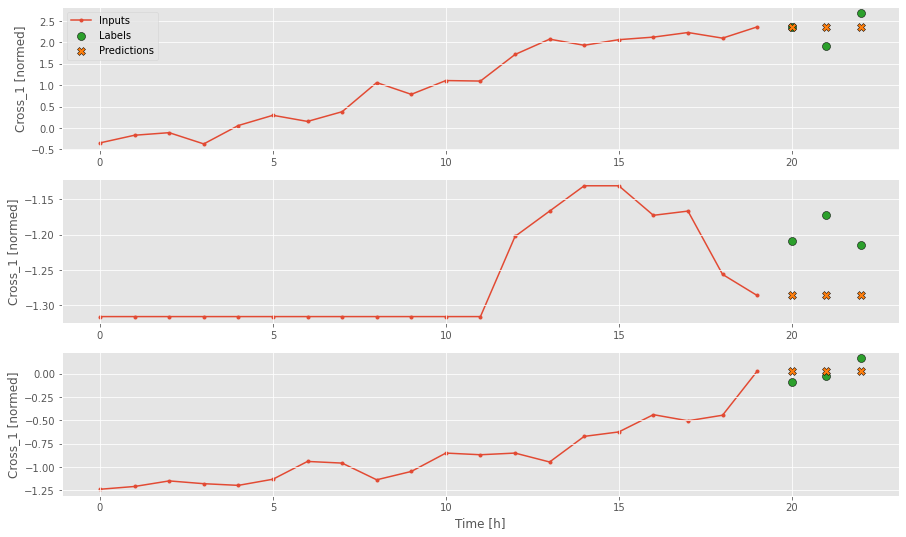

In [23]:
OUT_STEPS = 3
num_features = 6
class MultiStepLastBaseline(tf.keras.Model):
  def call(self, inputs):
    return tf.tile(inputs[:, -1:, :], [1, OUT_STEPS, 1])

last_baseline = MultiStepLastBaseline()
last_baseline.compile(loss=tf.losses.MeanSquaredError(),
                      metrics=[tf.metrics.MeanAbsoluteError()])

multi_val_performance = {}
multi_performance = {}

multi_val_performance['Last'] = last_baseline.evaluate(W4.val)
multi_performance['Last'] = last_baseline.evaluate(W4.test, verbose=0)
W4.plot(last_baseline)

##Multi-step Dense


In [24]:
multi_dense = Sequential()
multi_dense.add(Flatten())
multi_dense.add(Dense(64))
multi_dense.add(Dense(64))
multi_dense.add(Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()))
# Shape => [batch, out_steps*features]
multi_dense .add(Reshape([OUT_STEPS, num_features]))
multi_dense .compile(optimizer='adam', loss='mse')

print('Input shape:', W4.example[0].shape)
print('Output shape:', multi_dense(W4.example[0]).shape)

Input shape: (32, 20, 6)
Output shape: (32, 3, 6)


In [30]:
history = compile_and_fit(multi_dense, W4)

multi_val_performance['Dense'] = multi_dense.evaluate(W4.val)
multi_performance['Dense'] = multi_dense.evaluate(W4.test, verbose=0)

Epoch 1/20
289/289 [==============================] - 2s 5ms/step - loss: 0.1460 - mean_absolute_error: 0.2519 - val_loss: 0.1227 - val_mean_absolute_error: 0.2485
Epoch 2/20
289/289 [==============================] - 1s 5ms/step - loss: 0.0918 - mean_absolute_error: 0.2038 - val_loss: 0.0963 - val_mean_absolute_error: 0.2132
Epoch 3/20
289/289 [==============================] - 1s 5ms/step - loss: 0.0874 - mean_absolute_error: 0.1983 - val_loss: 0.0949 - val_mean_absolute_error: 0.2120
Epoch 4/20
289/289 [==============================] - 1s 5ms/step - loss: 0.0855 - mean_absolute_error: 0.1959 - val_loss: 0.1003 - val_mean_absolute_error: 0.2249
Epoch 5/20
289/289 [==============================] - 1s 5ms/step - loss: 0.0856 - mean_absolute_error: 0.1964 - val_loss: 0.0936 - val_mean_absolute_error: 0.2111
Epoch 6/20
289/289 [==============================] - 2s 5ms/step - loss: 0.0843 - mean_absolute_error: 0.1946 - val_loss: 0.0983 - val_mean_absolute_error: 0.2197
Epoch 7/20
82/82

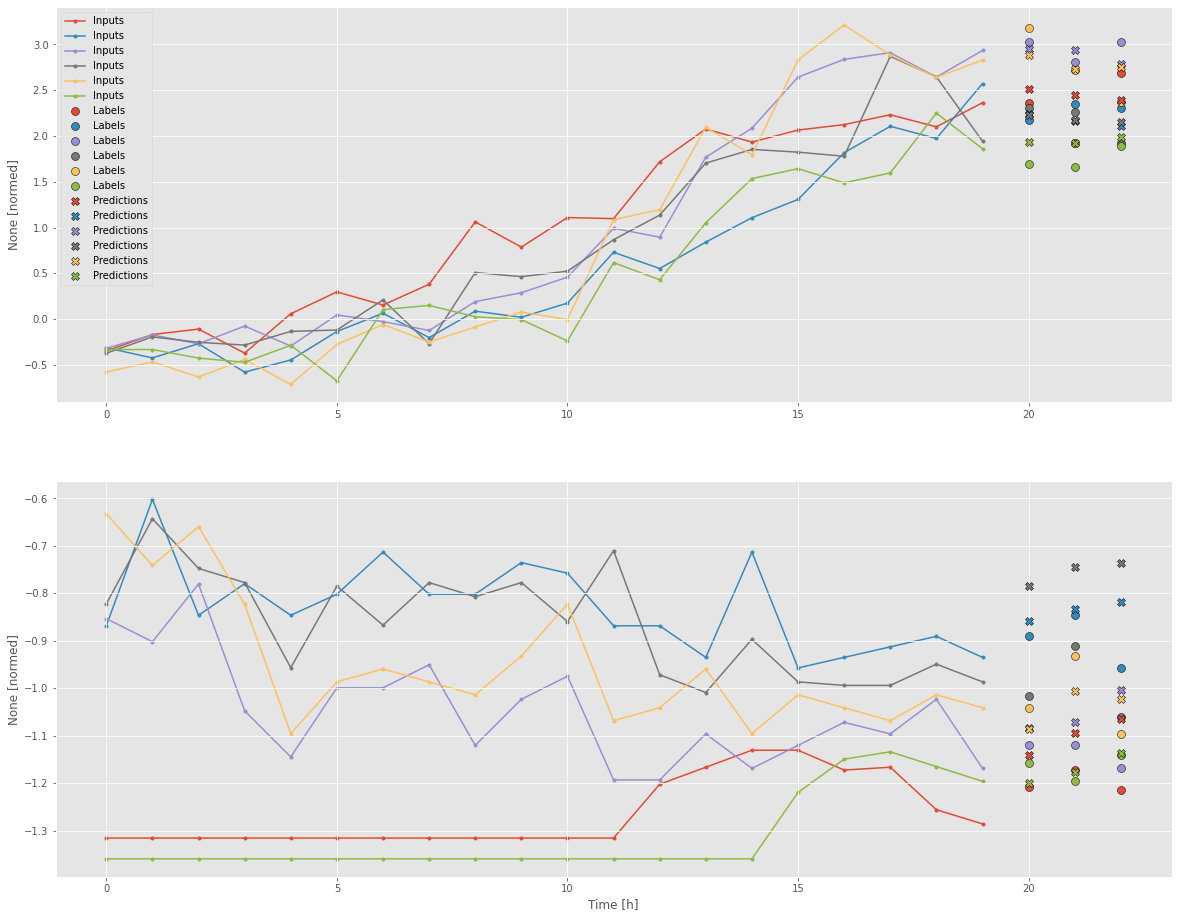

In [32]:
W4.multi_plot(multi_dense,max_subplots=2)

##GRU

In [25]:
gru_model = Sequential()
gru_model.add(GRU(64,return_sequences = True,input_shape=( W4.example[0].shape[1], W4.example[0].shape[2])))
gru_model.add(GRU(64))
gru_model.add(Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()))
gru_model .add(Reshape([OUT_STEPS, num_features]))
gru_model .compile(optimizer='adam', loss='mse')

print('Input shape:', W4.example[0].shape)
print('Output shape:', gru_model(W4.example[0]).shape)

Input shape: (32, 20, 6)
Output shape: (32, 3, 6)


In [26]:
history = compile_and_fit(gru_model, W4)

multi_val_performance['GRU model'] = gru_model.evaluate(W4.val)
multi_performance['GRU model'] = gru_model.evaluate(W4.test, verbose=0)

Epoch 1/20
289/289 [==============================] - 9s 15ms/step - loss: 0.2016 - mean_absolute_error: 0.2926 - val_loss: 0.1296 - val_mean_absolute_error: 0.2429
Epoch 2/20
289/289 [==============================] - 3s 10ms/step - loss: 0.0870 - mean_absolute_error: 0.1939 - val_loss: 0.1053 - val_mean_absolute_error: 0.2205
Epoch 3/20
289/289 [==============================] - 3s 10ms/step - loss: 0.0769 - mean_absolute_error: 0.1815 - val_loss: 0.0990 - val_mean_absolute_error: 0.2149
Epoch 4/20
289/289 [==============================] - 3s 10ms/step - loss: 0.0742 - mean_absolute_error: 0.1792 - val_loss: 0.0959 - val_mean_absolute_error: 0.2127
Epoch 5/20
289/289 [==============================] - 3s 9ms/step - loss: 0.0716 - mean_absolute_error: 0.1758 - val_loss: 0.0914 - val_mean_absolute_error: 0.2087
Epoch 6/20
289/289 [==============================] - 3s 9ms/step - loss: 0.0702 - mean_absolute_error: 0.1744 - val_loss: 0.0942 - val_mean_absolute_error: 0.2093
Epoch 7/20
8

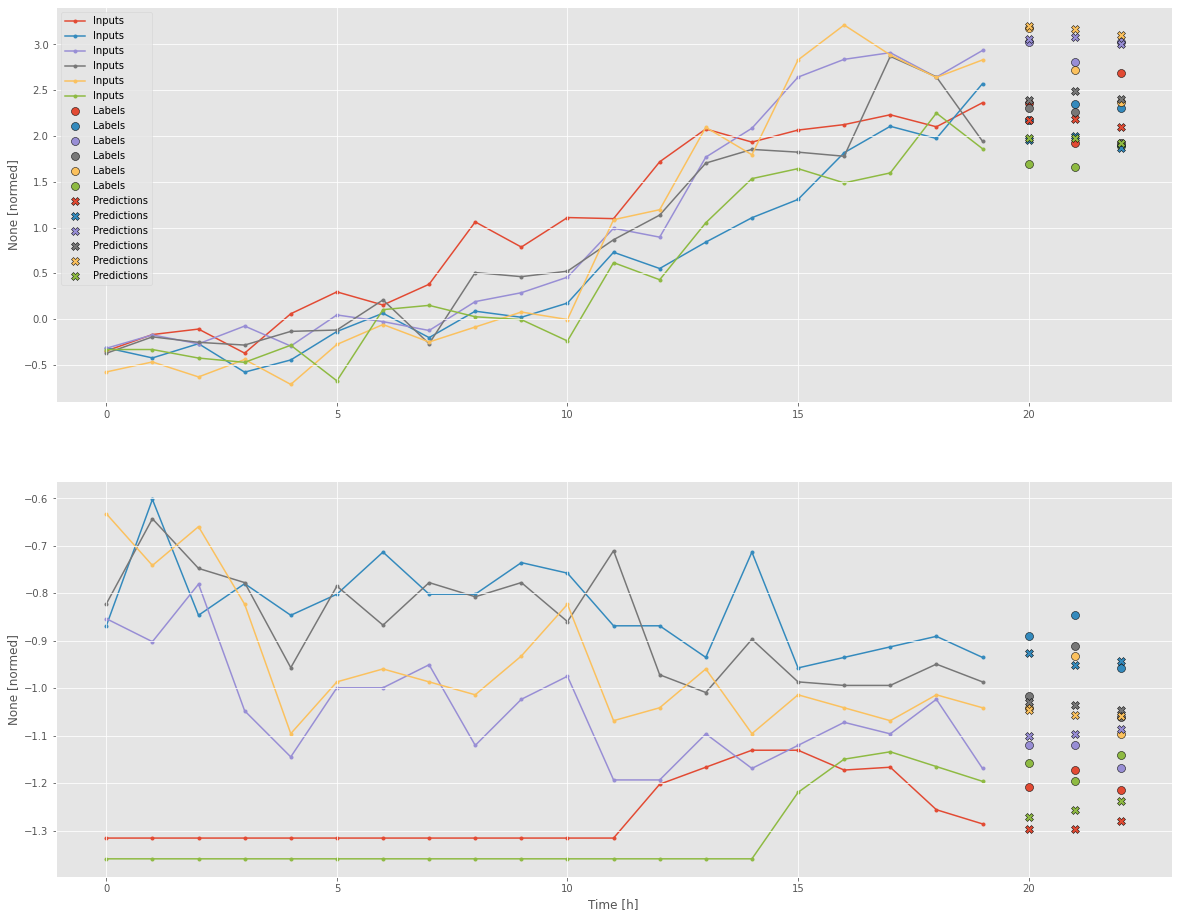

In [29]:
W4.multi_plot(gru_model,max_subplots=2)

##LSTM

In [33]:
multi_lstm_model = Sequential()
multi_lstm_model .add(LSTM(64, return_sequences=True,input_shape=( W4.example[0].shape[1], W4.example[0].shape[2])))
multi_lstm_model .add(LSTM(units=64,return_sequences=False))
multi_lstm_model .add(Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()))
    # Shape => [batch, out_steps, features].
multi_lstm_model .add(Reshape([OUT_STEPS, num_features]))
multi_lstm_model .compile(optimizer='adam', loss='mse')

print('Input shape:', W4.example[0].shape)
print('Output shape:', multi_lstm_model(W4.example[0]).shape)

Input shape: (32, 20, 6)
Output shape: (32, 3, 6)


In [36]:
history = compile_and_fit(multi_lstm_model, W4)

multi_val_performance['LSTM'] = multi_lstm_model.evaluate(W4.val)
multi_performance['LSTM'] = multi_lstm_model.evaluate(W4.test, verbose=0)

Epoch 1/20
289/289 [==============================] - 8s 13ms/step - loss: 0.0659 - mean_absolute_error: 0.1696 - val_loss: 0.0987 - val_mean_absolute_error: 0.2128
Epoch 2/20
289/289 [==============================] - 3s 10ms/step - loss: 0.0639 - mean_absolute_error: 0.1672 - val_loss: 0.0988 - val_mean_absolute_error: 0.2105
Epoch 3/20
82/82 [==============================] - 0s 5ms/step - loss: 0.1007 - mean_absolute_error: 0.2139


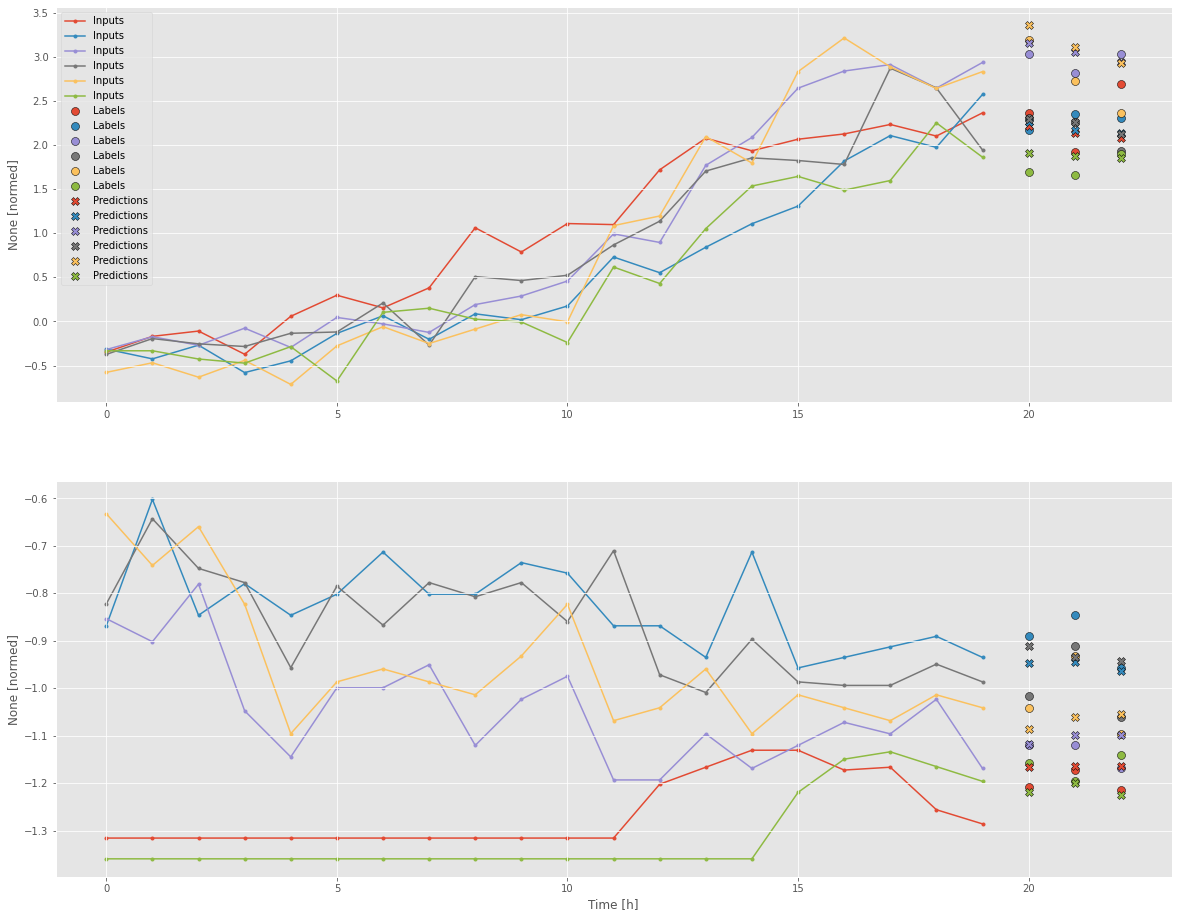

In [38]:
W4.multi_plot(multi_lstm_model,max_subplots=2)

##Performance

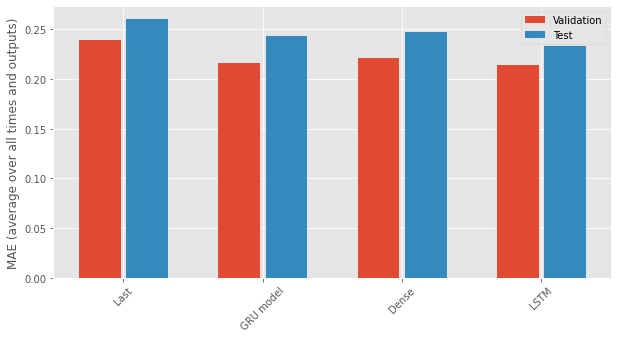

In [40]:
x = np.arange(len(multi_performance))
width = 0.3

metric_name = 'mean_absolute_error'
metric_index = multi_lstm_model.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in multi_val_performance.values()]
test_mae = [v[metric_index] for v in multi_performance.values()]

plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=multi_performance.keys(),
           rotation=45)
plt.ylabel(f'MAE (average over all times and outputs)')
_ = plt.legend()

In [41]:
for name, value in multi_performance.items():
  print(f'{name:8s}: {value[1]:0.4f}')

Last    : 0.2597
GRU model: 0.2428
Dense   : 0.2467
LSTM    : 0.2332
